**Import Libraries**

In [1]:
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

W0708 17:37:51.925051 139624952112768 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


**Read CSV File and Randomize**

In [2]:
votes_dataframe = pd.read_csv("vote_csv.csv")
#Yes 1
#No -1
#NaN 0
#Republican 1
#Democrat -1
votes_dataframe = votes_dataframe.replace("y", 1)
votes_dataframe = votes_dataframe.replace("n", -1)
votes_dataframe = votes_dataframe.replace("republican", 1)
votes_dataframe = votes_dataframe.replace("democrat", -1)
votes_dataframe = votes_dataframe.fillna(0)
votes_dataframe = votes_dataframe.reindex(np.random.permutation(votes_dataframe.index))

**Create Training and Validation Data**

In [3]:
def preprocess_features(votes_dataframe):
    output_features = votes_dataframe.iloc[:,0:16]
    
    return output_features

In [4]:
#Single Panda Series
def preprocess_targets(votes_dataframe):
    output_targets = votes_dataframe["Class"]

    return output_targets

In [5]:
training_split = int(0.6 * len(votes_dataframe))
validations_split = int(0.3 * len(votes_dataframe))

#Panda Data
training_examples = preprocess_features(votes_dataframe.iloc[0:training_split])
training_targets = preprocess_targets(votes_dataframe.iloc[0:training_split])
validation_examples = preprocess_features(votes_dataframe.iloc[training_split:training_split + validations_split])
validation_targets = preprocess_targets(votes_dataframe.iloc[training_split:training_split + validations_split])
#Do not touch until end!
test_examples = preprocess_features(votes_dataframe.iloc[training_split + validations_split:])
test_targets = preprocess_targets(votes_dataframe.iloc[training_split + validations_split:])

**Training Functions**

In [6]:
#From Google Crash Course
#Create Tensorflow Columns
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [7]:
#Return next batch (Of type of Tensorflow Dataset)
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), targets))
    
    if(shuffle):
        dataset = dataset.shuffle(1000)
    
    dataset = dataset.batch(batch_size).repeat(num_epochs)
    
    return dataset

In [8]:
def train_linear_regression_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
    
    #Initialize Linear Regressor
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=optimizer
    )
    
    #Training Functions
    training_input_fn = lambda: input_fn(
        training_examples,
        training_targets,
        batch_size=batch_size) 
    predict_training_input_fn = lambda: input_fn(
        training_examples, 
        training_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Validation Function
    predict_validation_input_fn = lambda: input_fn(
        validation_examples, 
        validation_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Train Model
    training_rmse = []
    validation_rmse = []
    
    print("Training Model")
    for period in range(0, periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            #Manually break total steps by 10
            steps=steps_per_period
        )
        
        #Use Sklearn to calculate RMSE
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        
        #Calculate Validation RMSE
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        #Append Losses
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
        print("Period:", period, "RMSE:", training_root_mean_squared_error)
    print("Training Finished")
    
    #Graph
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

In [9]:
def train_dnn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods
    
    #Initialize DNN Regressor
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer,
    )
    
    #Training Functions
    training_input_fn = lambda: input_fn(
        training_examples,
        training_targets,
        batch_size=batch_size) 
    predict_training_input_fn = lambda: input_fn(
        training_examples, 
        training_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Validation Function
    predict_validation_input_fn = lambda: input_fn(
        validation_examples, 
        validation_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Train Model
    training_rmse = []
    validation_rmse = []
    
    print("Training Model")
    for period in range(0, periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            #Manually break total steps by 10
            steps=steps_per_period
        )
        
        #Use Sklearn to calculate RMSE
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        
        #Calculate Validation RMSE
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        #Append Losses
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
        print("Period:", period, "RMSE:", training_root_mean_squared_error)
    print("Training Finished")
    
    #Graph
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return dnn_regressor

**Training**

W0708 17:37:53.333325 139624952112768 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0708 17:37:53.334676 139624952112768 estimator.py:1811] Using temporary folder as model directory: /tmp/tmp264c2eo1
W0708 17:37:53.343930 139624952112768 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Training Model


W0708 17:37:53.954066 139624952112768 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:308: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0708 17:37:54.579551 139624952112768 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/clip_ops.py:286: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0708 17:37:56.757318 139624952112768 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for f

Period: 0 RMSE: 0.8083479459363658


W0708 17:37:59.172003 139624952112768 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


Period: 1 RMSE: 0.6566101601441228
Period: 2 RMSE: 0.5593183035323789
Period: 3 RMSE: 0.5071407595042766


W0708 17:38:14.884146 139624952112768 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Period: 4 RMSE: 0.476952805815263
Period: 5 RMSE: 0.4524492145634802
Period: 6 RMSE: 0.43525666657539913
Period: 7 RMSE: 0.41968074446859005
Period: 8 RMSE: 0.4079658081627736
Period: 9 RMSE: 0.39692340764797085
Training Finished


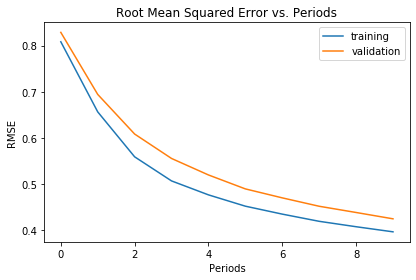

In [10]:
linear_regressor = train_linear_regression_model(
    learning_rate=0.001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

W0708 17:38:42.270006 139624952112768 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpms6t4xnb


Training Model
Period: 0 RMSE: 0.37812865145031094
Period: 1 RMSE: 0.36593827308245674
Period: 2 RMSE: 0.3577469889725841
Period: 3 RMSE: 0.3523362193971844
Period: 4 RMSE: 0.34809465488287217
Period: 5 RMSE: 0.34560883378831453
Period: 6 RMSE: 0.3451875854849876
Period: 7 RMSE: 0.343404906963845
Period: 8 RMSE: 0.34284474456246267
Period: 9 RMSE: 0.3416863531523725
Training Finished


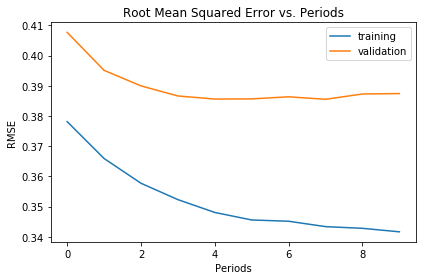

In [11]:
dnn_regressor = train_dnn_regression_model(
    learning_rate=0.1,
    steps=500,
    batch_size=20,
    hidden_units=[3, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

**Test Data**

In [12]:
def test_model(model, test_examples, test_targets):
    predict_test_input_fn = lambda: input_fn(
        test_examples, 
        test_targets, 
        num_epochs=1, 
        shuffle=False)
    
    test_predictions = model.predict(input_fn=predict_test_input_fn)
    test_predictions = np.array([item['predictions'][0] for item in test_predictions])

    for prediction, label in zip(test_predictions, test_targets): 
        if(prediction * label > 0):
            print("Prediction:", prediction, "Label:", label)
        else:
            print("Prediction:", prediction, "Label:", label, "WRONG")
    
    return test_predictions

In [13]:
#Linear Regressor
test_predictions_linear_regressor = test_model(linear_regressor, test_examples, test_targets)
test_rmse_linear_regressor = math.sqrt(metrics.mean_squared_error(test_predictions_linear_regressor, test_targets))
print("Test RMSE:", test_rmse_linear_regressor)

Prediction: 0.6164861 Label: 1
Prediction: -1.1835783 Label: -1
Prediction: -1.0391731 Label: -1
Prediction: -0.89797485 Label: -1
Prediction: -1.0209252 Label: -1
Prediction: 0.96426606 Label: 1
Prediction: 0.89276206 Label: 1
Prediction: -1.2042096 Label: -1
Prediction: -1.1592752 Label: -1
Prediction: 0.7956326 Label: 1
Prediction: 0.45947906 Label: 1
Prediction: -0.09892872 Label: 1 WRONG
Prediction: -0.8600235 Label: -1
Prediction: -0.9416822 Label: -1
Prediction: -0.9128753 Label: -1
Prediction: 0.84131575 Label: 1
Prediction: 0.95098305 Label: 1
Prediction: -1.1169711 Label: -1
Prediction: 1.2948503 Label: 1
Prediction: 0.6193651 Label: 1
Prediction: 0.7245418 Label: 1
Prediction: 0.3208957 Label: -1 WRONG
Prediction: 0.817634 Label: 1
Prediction: -0.85641956 Label: -1
Prediction: 0.9078262 Label: 1
Prediction: -0.12387352 Label: -1
Prediction: 0.66330945 Label: 1
Prediction: -1.0001476 Label: -1
Prediction: -0.9474318 Label: -1
Prediction: 1.0063522 Label: 1
Prediction: -0.9101

In [14]:
#DNN Regressor
test_predictions_dnn_regressor = test_model(dnn_regressor, test_examples, test_targets)
test_rmse_dnn_regressor = math.sqrt(metrics.mean_squared_error(test_predictions_dnn_regressor, test_targets))
print("Test RMSE:", test_rmse_dnn_regressor)

W0708 17:39:28.339543 139624952112768 deprecation.py:506] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Prediction: 0.0 Label: 1 WRONG
Prediction: 0.16961041 Label: -1 WRONG
Prediction: -0.028006822 Label: -1
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.0 Label: 1 WRONG
Prediction: -0.092265844 Label: 1 WRONG
Prediction: 0.07409173 Label: -1 WRONG
Prediction: 1.044854 Label: -1 WRONG
Prediction: 0.0 Label: 1 WRONG
Prediction: 0.16754141 Label: 1
Prediction: 0.0 Label: 1 WRONG
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.0 Label: 1 WRONG
Prediction: 0.0 Label: 1 WRONG
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.0 Label: 1 WRONG
Prediction: 0.0 Label: 1 WRONG
Prediction: 0.75065863 Label: 1
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.46503505 Label: 1
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.0 Label: 1 WRONG
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.0 Label: 1 WRONG
Prediction: 0.0 Label: -1 WRONG
Prediction: 0.0383472 Label: -1 WRONG
Prediction: 0.0 Label: 1 WRONG
Prediction: 0.0

**Additional Info**

In [15]:
#Linear Regressor Weights
for v in linear_regressor.get_variable_names():
    print(v, linear_regressor.get_variable_value(v))

global_step 700
linear/linear_model/adoption-of-the-budget-resolution/weights [[-0.23027962]]
linear/linear_model/aid-to-nicaraguan-contras/weights [[0.05834165]]
linear/linear_model/anti-satellite-test-ban/weights [[0.07369523]]
linear/linear_model/bias_weights [-0.09892872]
linear/linear_model/crime/weights [[0.00636355]]
linear/linear_model/duty-free-exports/weights [[-0.02077765]]
linear/linear_model/education-spending/weights [[0.04568315]]
linear/linear_model/el-salvador-aid/weights [[0.07189324]]
linear/linear_model/export-administration-act-south-africa/weights [[0.01221219]]
linear/linear_model/handicapped-infants/weights [[0.00134412]]
linear/linear_model/immigration/weights [[0.02714911]]
linear/linear_model/mx-missile/weights [[-0.0249448]]
linear/linear_model/physician-fee-freeze/weights [[0.6996167]]
linear/linear_model/religious-groups-in-schools/weights [[-0.04168759]]
linear/linear_model/superfund-right-to-sue/weights [[0.01273647]]
linear/linear_model/synfuels-corpora

In [16]:
#DNN Regressor Weights
#for v in dnn_regressor.get_variable_names():
#    print(v, "\n", dnn_regressor.get_variable_value(v))